# Generating and Segmenting with Character-Level Transformer

In [165]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd

phoible = pd.read_csv('../data/phoible.csv')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_90348/1538564286.py:6: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../data/phoible.csv')


## Load corpus

In [1]:
from datasets import load_dataset
dataset = load_dataset('transformersegmentation/CHILDES', 'English')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'gloss', 'stem', 'type', 'language', 'num_morphemes', 'num_tokens', 'part_of_speech', 'speaker_role', 'target_child_age', 'target_child_sex', 'collection_id', 'corpus_id', 'speaker_id', 'target_child_id', 'transcript_id', 'is_child', 'processed_gloss', 'phonemized_utterance', 'language_code', 'character_split_utterance'],
        num_rows: 1636954
    })
    valid: Dataset({
        features: ['id', 'gloss', 'stem', 'type', 'language', 'num_morphemes', 'num_tokens', 'part_of_speech', 'speaker_role', 'target_child_age', 'target_child_sex', 'collection_id', 'corpus_id', 'speaker_id', 'target_child_id', 'transcript_id', 'is_child', 'processed_gloss', 'phonemized_utterance', 'language_code', 'character_split_utterance'],
        num_rows: 10000
    })
})

## Load model

In [16]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.models.gpt2 import GPT2FeatureModel, GPT2LMHeadModel
from src.preprocessing import create_phoneme_map


tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-Tokenizer')
phoneme_map = create_phoneme_map(tokenizer, '../data/phoible.csv')
#model = GPT2FeatureModel.from_pretrained('transformersegmentation/GPT2-gpt2_feature_model-model', revision='english', feature_map=phoneme_map)
#model.return_token_logits = True
model = GPT2LMHeadModel.from_pretrained('transformersegmentation/grid-search-gpt2_lm_head_model-model', revision='English-02611')

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks/../src/preprocessing.py:29: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


In [5]:
# Generate a sample
input_ids = tokenizer.encode('h', return_tensors='pt')
sample_outputs = model.generate(input_ids, do_sample=True, max_length=50, top_k=10, top_p=0.95, num_return_sequences=3, pad_token_id=tokenizer.pad_token_id)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: h æ v s ʌ m m oː ɹ t ɔɪ z UTT_BOUNDARY j ɛ h UTT_BOUNDARY w ʌ t k ʌ l ɚ ɹ ɪ z ð æ t UTT_BOUNDARY w ʌ t d uː j uː θ ɪ ŋ k UTT_BOUNDARY h eɪ h eɪ s w iː
1: h ɛ v ə n t iː t iː t̠ʃ ɚ UTT_BOUNDARY w iː l ɡ ɛ t ɪ t UTT_BOUNDARY n oʊ n oʊ UTT_BOUNDARY j uː m iː n m oː ɹ ɪ n h ɪ z k ɑː n s ɛ t UTT_BOUNDARY w aɪ d oʊ
2: h iː ɪ z UTT_BOUNDARY j uː ɡ ə n ə b aɪ t j ʊ ɹ t iː θ UTT_BOUNDARY aɪ w ʌ z n̩ t h ɜː d h ɪ m UTT_BOUNDARY j ɛ s UTT_BOUNDARY w ɛ n t b aɪ t UTT_BOUNDARY ɪ n ɐ l


## Attention Visualisation

In [6]:
import matplotlib.pyplot as plt
import seaborn

Utterance:  ðɛɹz ɐ feɪs wɪð ɡlæsɪz 
Encoder Layer 1


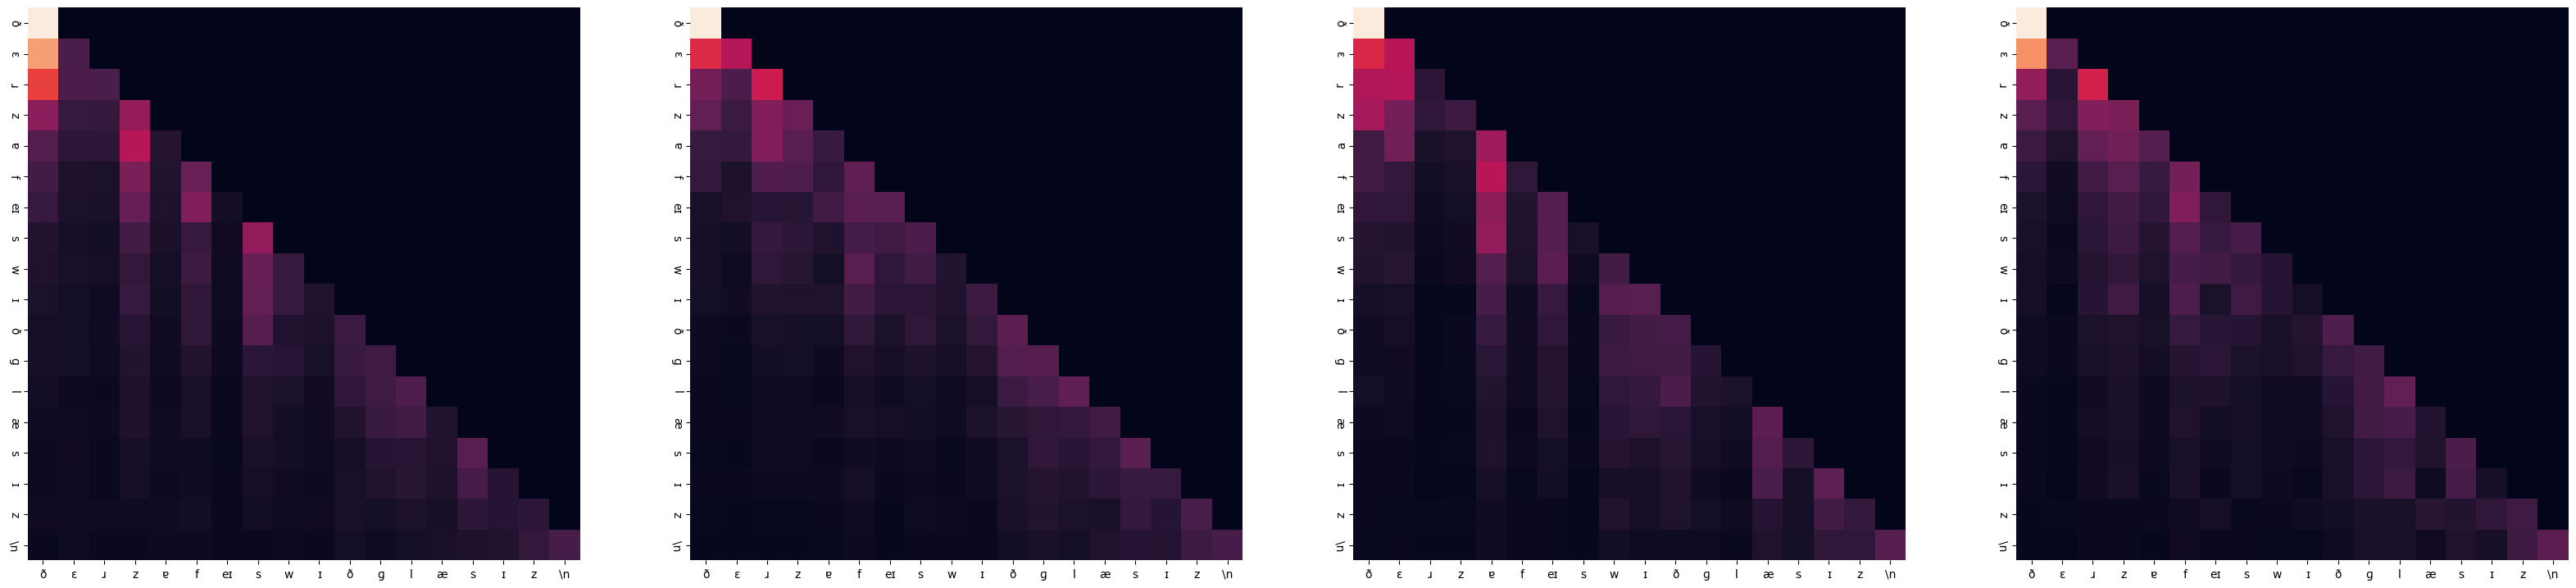

Encoder Layer 2


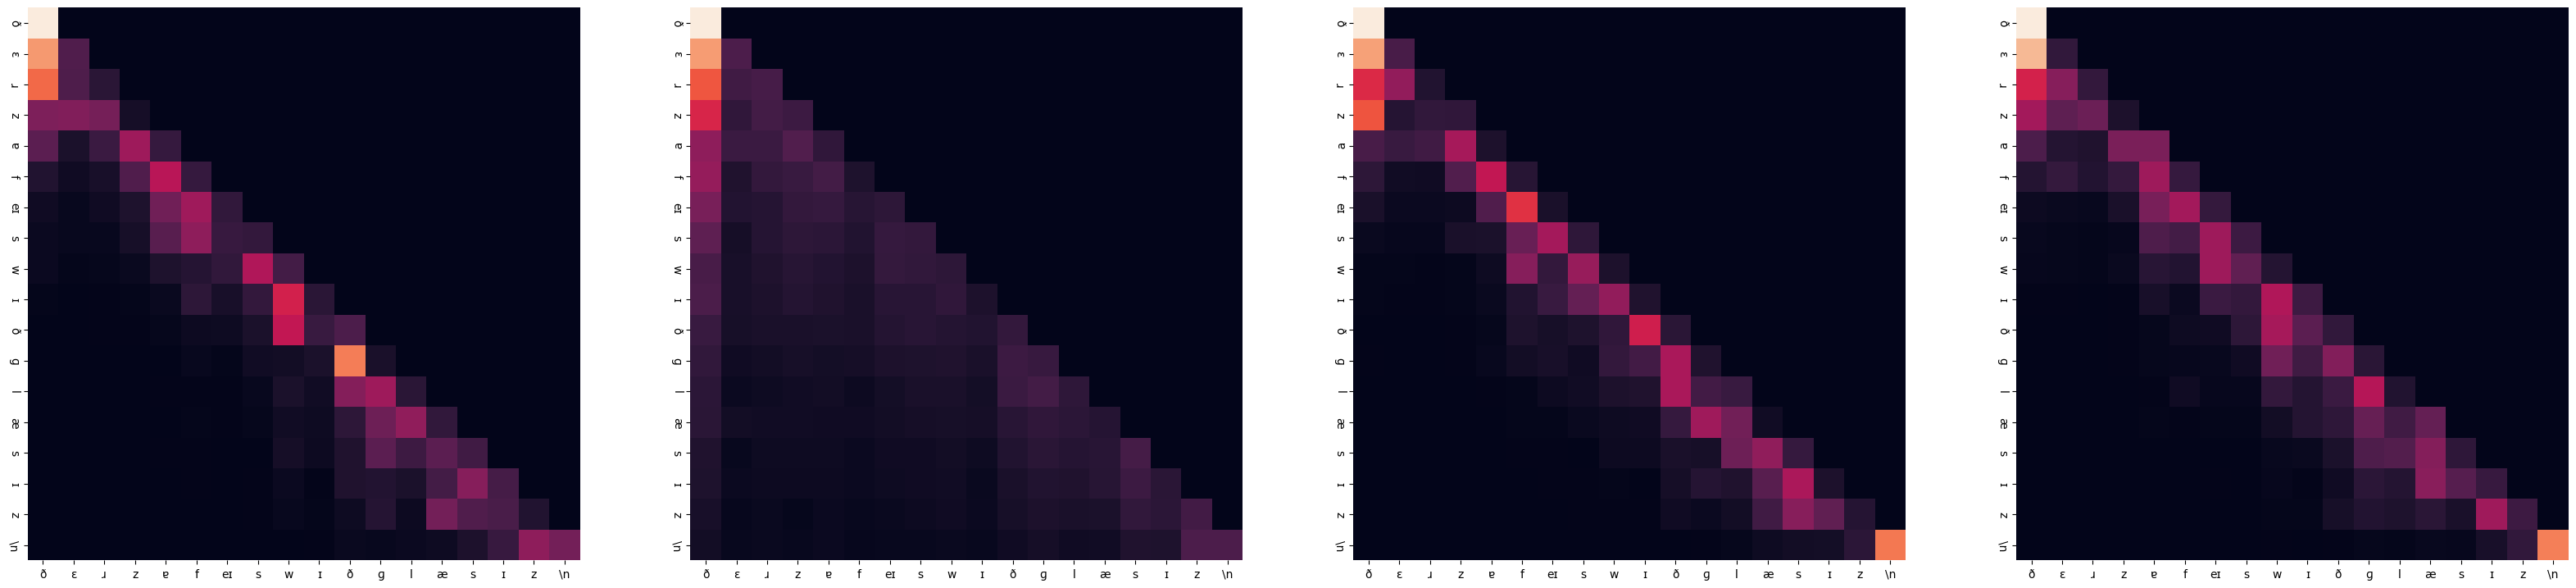

Encoder Layer 3


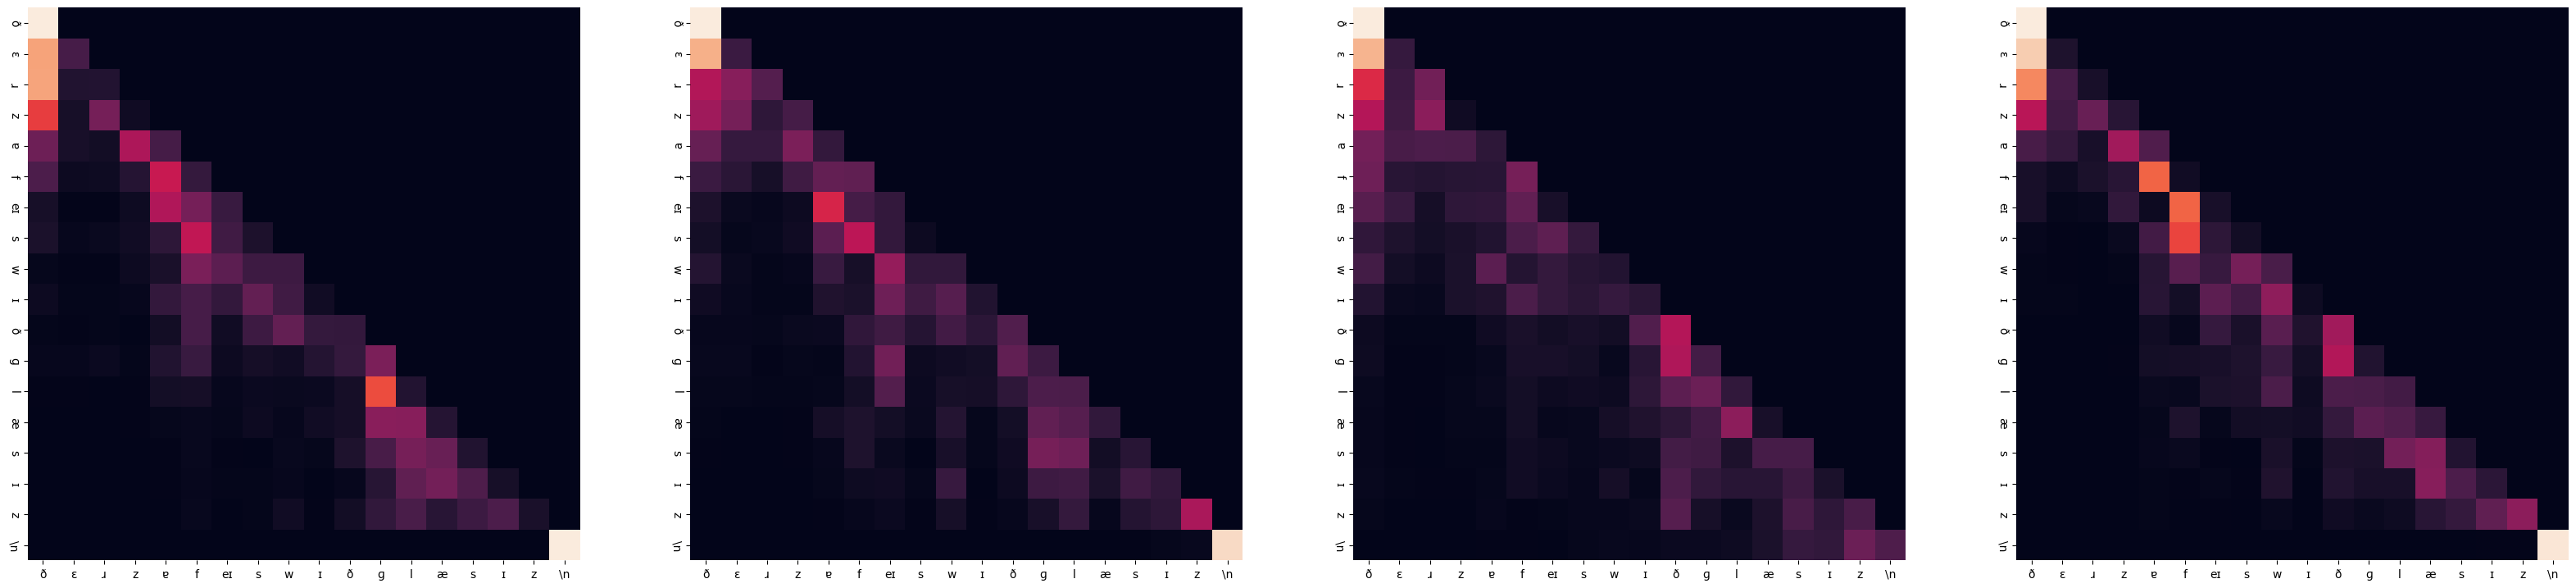

Encoder Layer 4


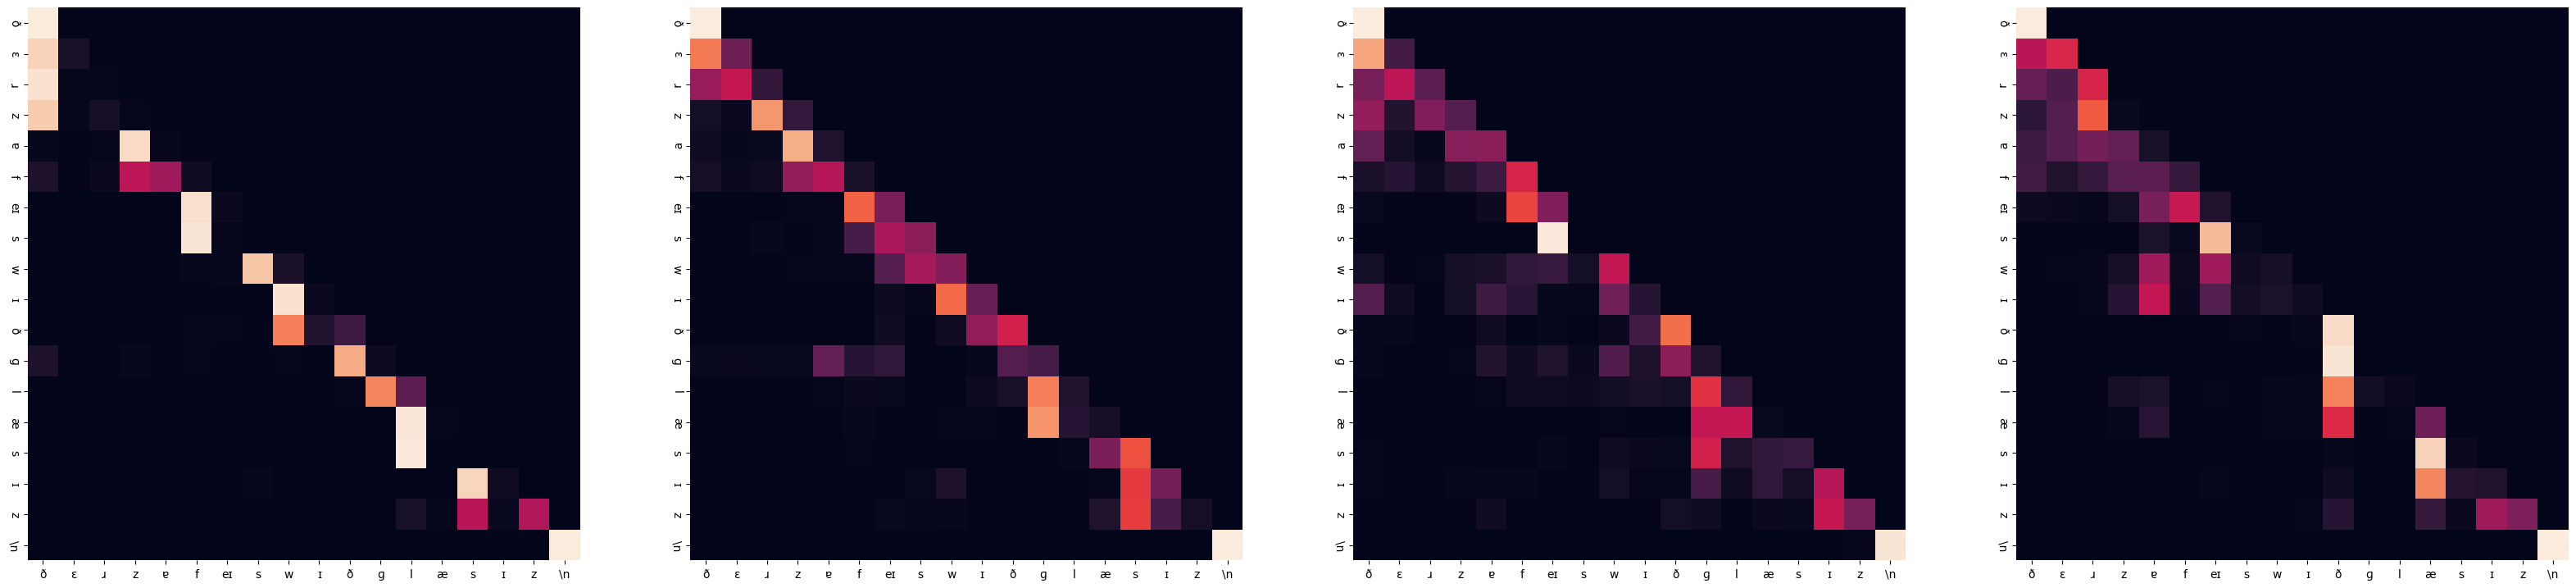

Encoder Layer 5


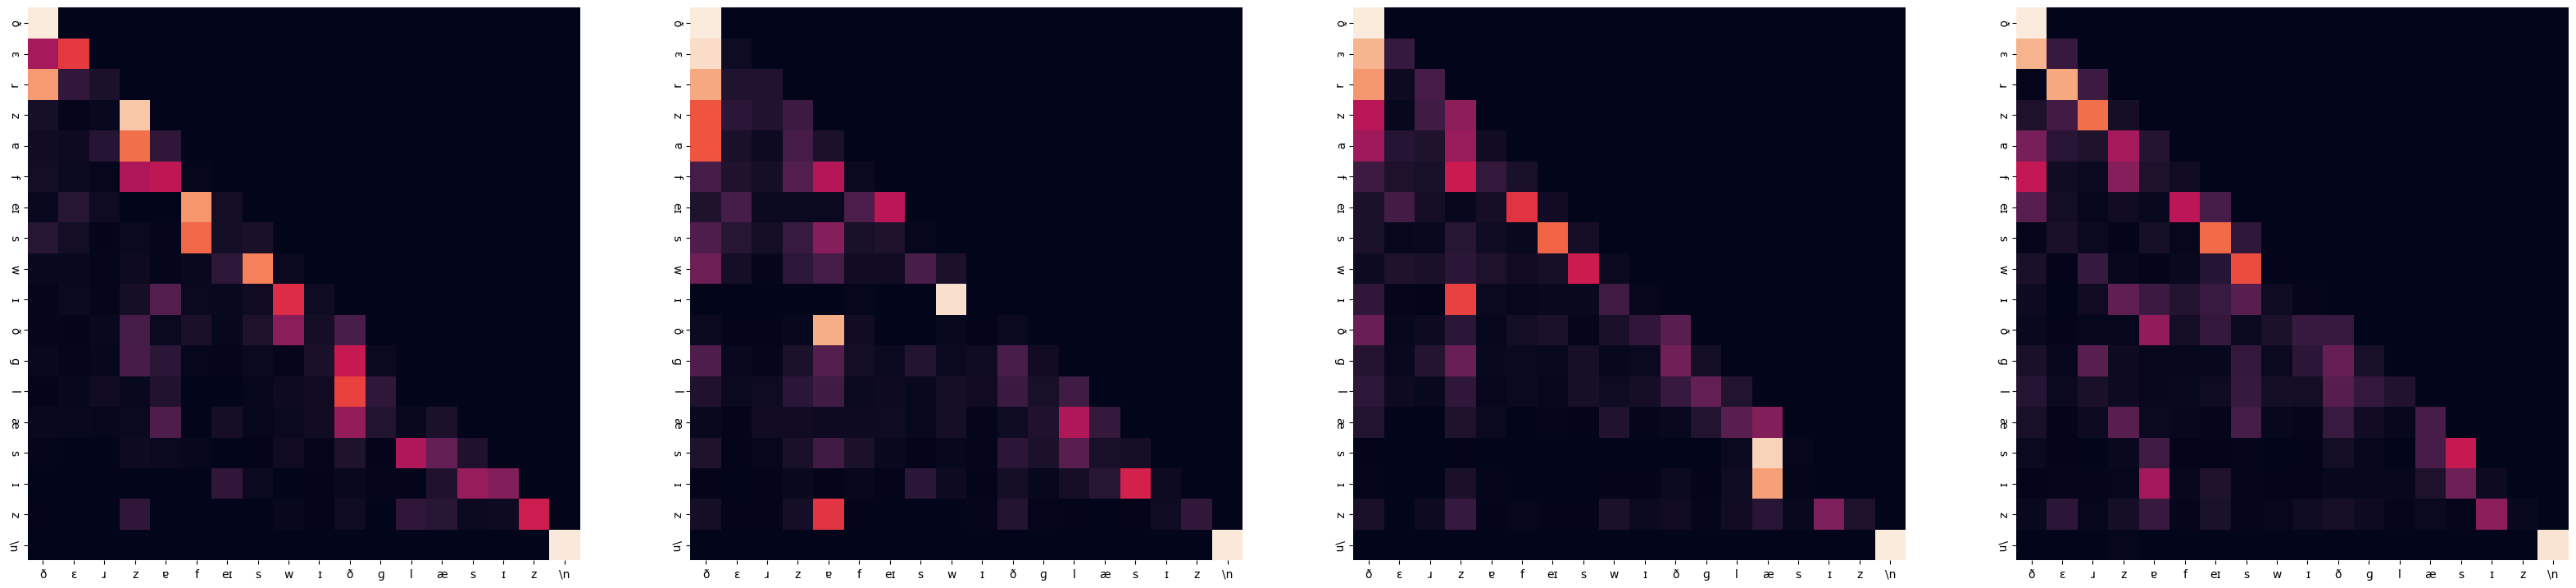

In [12]:
prompt = dataset['train']['phonemized_utterance'][1]
print("Utterance: ", prompt.replace(' ','').replace('WORD_BOUNDARY', ' '))
prompt = prompt.replace(' WORD_BOUNDARY', '')
prompt = prompt + ' UTT_BOUNDARY'

num_heads = model.config.n_head

def visualise_attention(prompt):
    input = tokenizer.encode(prompt, return_tensors='pt')
    prompt_text = tokenizer.convert_ids_to_tokens(input[0])
    prompt_text[-1] = '\\n'
    out = model.forward(input, labels=input, output_attentions=True, output_hidden_states=True, return_dict=True)
    attentions = [att.detach().numpy() for att in out.attentions]
    
    for layer in range(0, len(attentions), 1):
        fig, axs = plt.subplots(1,num_heads, figsize=(40, 20))
        print("Encoder Layer", layer+1)
        for h in range(num_heads):
            seaborn.heatmap(attentions[layer][:,h][0], 
                xticklabels=prompt_text, square=True, yticklabels=prompt_text, vmin=0, vmax=1,
                cbar=False, ax=axs[h])
            # Rotate x-axis labels by 90 degrees
            for item in axs[h].get_yticklabels():
                item.set_rotation(-90)
        plt.show()

visualise_attention(prompt)



In [49]:
english_phoneme_data = phoible#[phoible['LanguageName'].isin(['English (American)', 'American English'])]

# Get the input embedding layer for every phoneme
english_phonemes_count = {}
for utterance in list(dataset['train']['phonemized_utterance']):
    for pho in utterance.split():
        if pho in english_phonemes_count:
            english_phonemes_count[pho] += 1
        else:
            english_phonemes_count[pho] = 1
# Only include phonemes that appear more than 100 times
english_phonemes = [pho for pho in english_phonemes_count.keys() if english_phonemes_count[pho] > 100]
# Remove any tokens not in tokenizer or english phoneme data
english_phonemes = [pho for pho in english_phonemes if pho in tokenizer.get_vocab() and pho in english_phoneme_data.Phoneme.unique()]
print(english_phonemes)

['s', 'iː', 'ð', 'ɛ', 'ɹ', 'z', 'ɐ', 'f', 'eɪ', 'w', 'ɪ', 'ɡ', 'l', 'æ', 'ɑː', 'h', 'ə', 'ʊ', 'k', 'p', 'uː', 'b', 'i', 'ɾ', 't', 'aɪ', 'θ', 'ŋ', 'j', 'oː', 'm', 'ɔɪ', 'n', 'd', 'ʌ', 'oʊ', 'ɔ', 'aʊ', 'v', 'ɜː', 't̠ʃ', 'd̠ʒ', 'ɔː', 'ɚ', 'ʃ', 'ʔ', 'n̩', 'ʒ']


In [84]:
# Get embeddings
input_embeddings = np.zeros((len(english_phonemes), model.config.n_embd))
for i, pho in enumerate(english_phonemes):
    input_ids = tokenizer.encode(pho, return_tensors='pt')
    out = model.forward(input_ids, output_hidden_states=True, return_dict=True)
    input_embeddings[i] = out.hidden_states[0].detach().numpy()

# Project embeddings to 2D
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10)
X_embedded = tsne.fit_transform(input_embeddings)

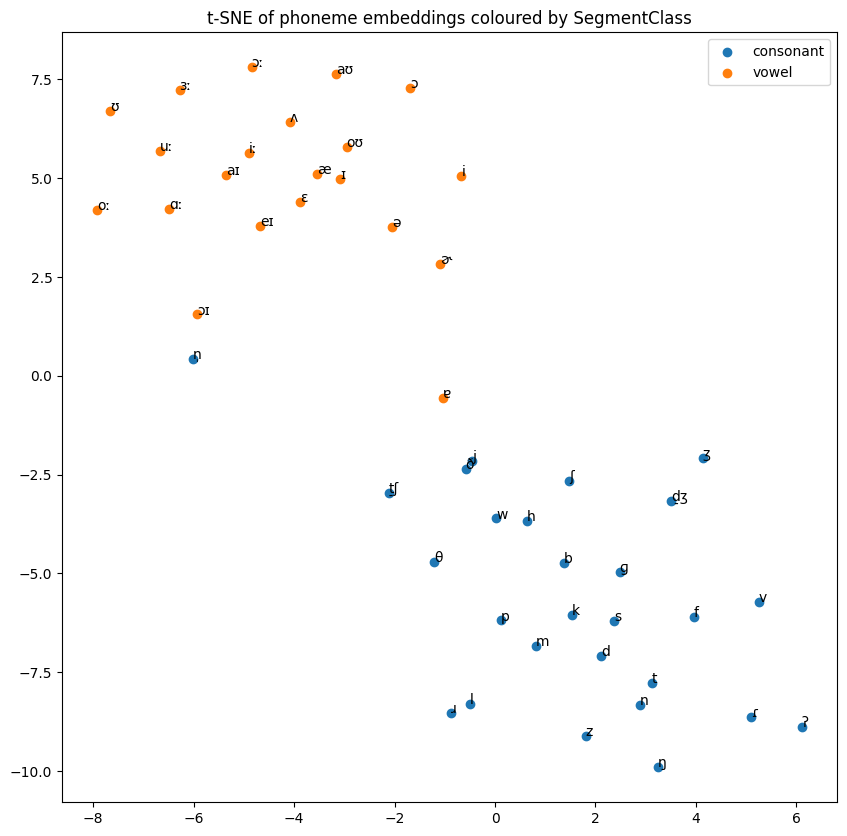

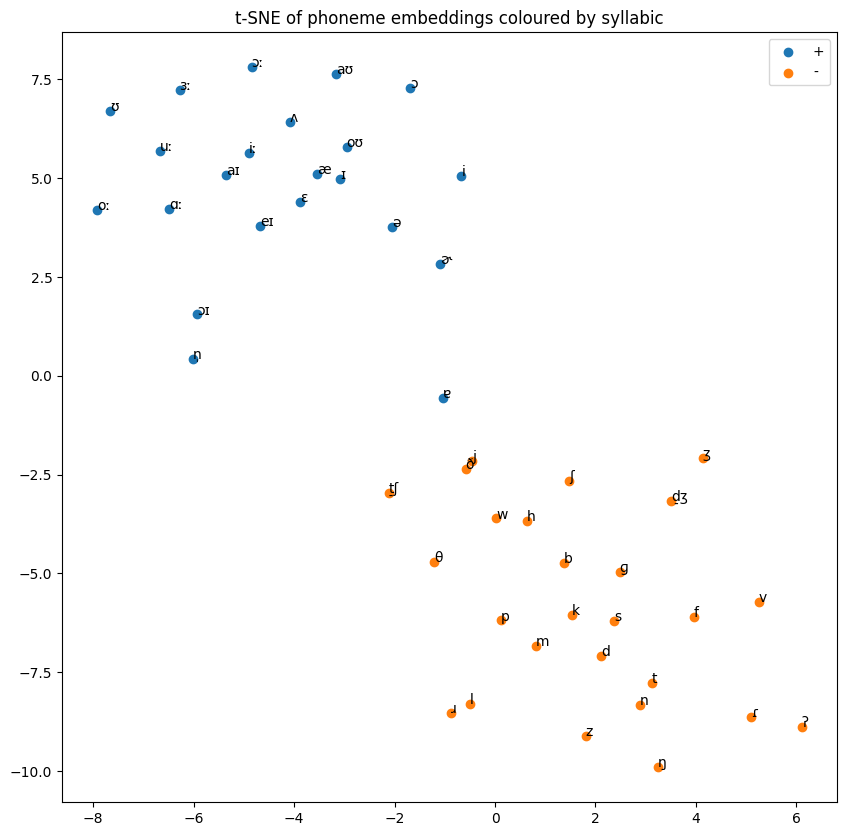

In [179]:
# Plot embeddings with phoneme labels

all_possible_features = ["syllabic", "tone","stress","short","long","consonantal","sonorant","continuant","delayedRelease","approximant","tap","trill","nasal","lateral","labial","round","labiodental","coronal","anterior","distributed","strident","dorsal","high","low","front","back","tense","retractedTongueRoot","advancedTongueRoot","periodicGlottalSource","epilaryngealSource","spreadGlottis","constrictedGlottis","fortis","lenis","raisedLarynxEjective","loweredLarynxImplosive","click"]

def plot_phoneme_embeddings(embeddings, phonemes, features):
    for feature in features:
        feature_map = [english_phoneme_data[english_phoneme_data['Phoneme'] == pho][feature].values[0] for pho in phonemes]

        plt.figure(figsize=(10, 10))
        for i, value in enumerate(np.unique(feature_map)):
            indices = [j for j, val in enumerate(feature_map) if val == value]
            plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=value)
            for j in indices:
                plt.annotate(phonemes[j], (embeddings[j, 0], embeddings[j, 1]))
        plt.title(f"t-SNE of phoneme embeddings coloured by {feature}")
        plt.legend()
        plt.show()

features = ['SegmentClass', 'syllabic']
plot_phoneme_embeddings(X_embedded, english_phonemes, features)


['iː', 'ɛ', 'ɐ', 'eɪ', 'ɪ', 'æ', 'ɑː', 'ə', 'ʊ', 'uː', 'i', 'aɪ', 'oː', 'ɔɪ', 'ʌ', 'oʊ', 'ɔ', 'aʊ', 'ɜː', 'ɔː', 'ɚ']
(21, 128)
['s', 'ð', 'ɹ', 'z', 'f', 'w', 'ɡ', 'l', 'h', 'k', 'p', 'b', 'ɾ', 't', 'θ', 'ŋ', 'j', 'm', 'n', 'd', 'v', 't̠ʃ', 'd̠ʒ', 'ʃ', 'ʔ', 'n̩', 'ʒ']


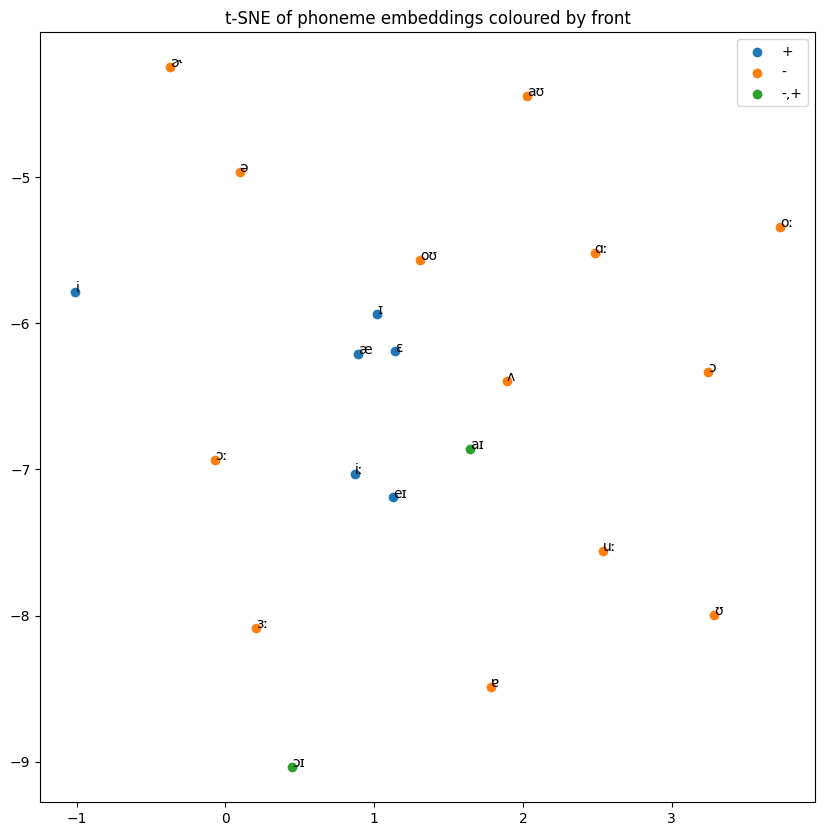

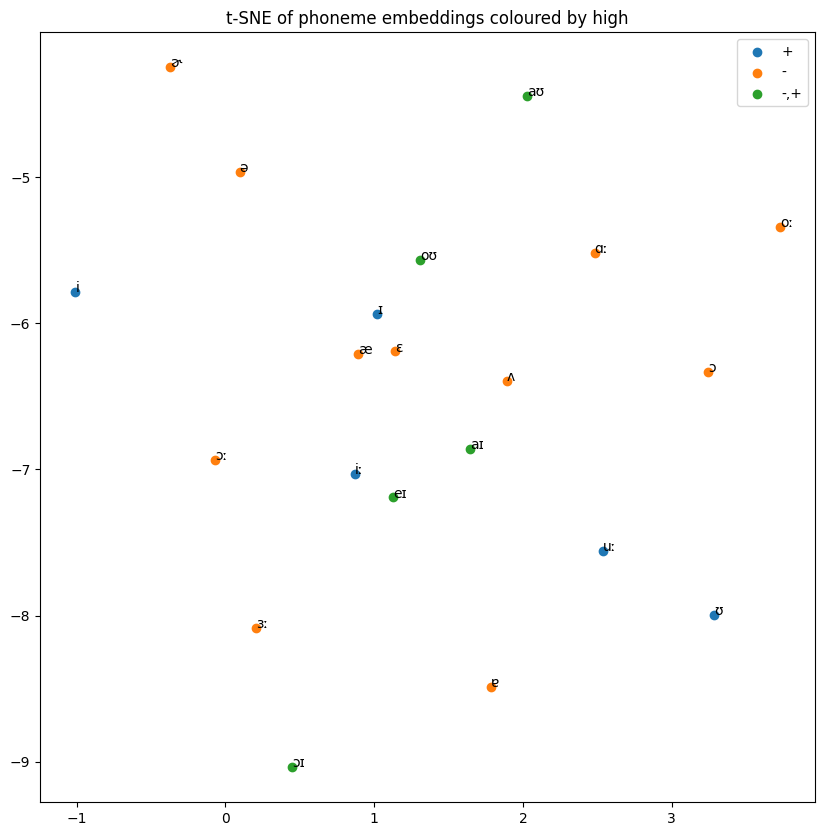

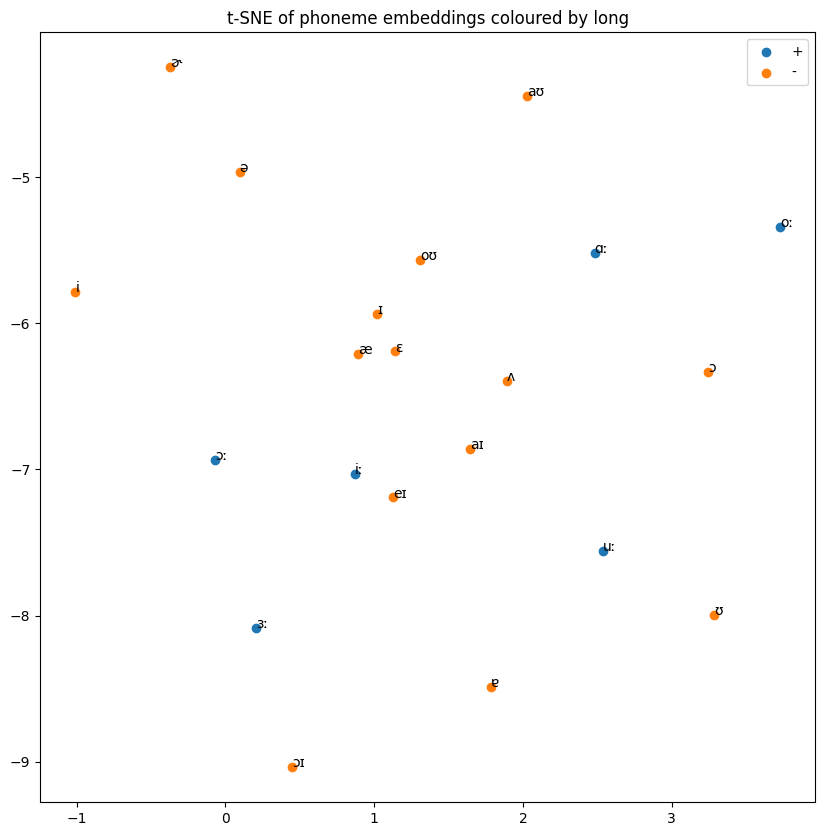

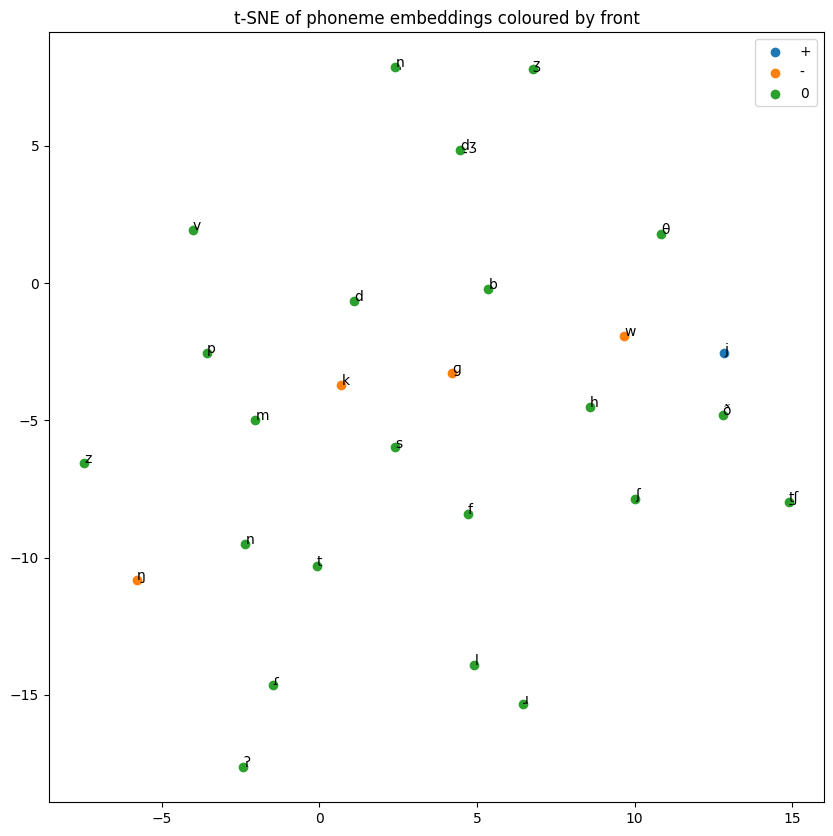

In [180]:
# Do TSNE again but just vowels
vowels = [pho for pho in english_phonemes if english_phoneme_data[english_phoneme_data['Phoneme'] == pho]['SegmentClass'].values[0] == 'vowel']
vowel_embeddings = [input_embeddings[english_phonemes.index(pho)] for pho in vowels]
print(vowels)
vowel_embeddings = np.array(vowel_embeddings)
print(vowel_embeddings.shape)
vowel_phonemes = vowels
tsne = TSNE(n_components=2, perplexity=8)
X_embedded_vowels = tsne.fit_transform(vowel_embeddings)

# Do TSNE again but just consonants
consonants = [pho for pho in english_phonemes if english_phoneme_data[english_phoneme_data['Phoneme'] == pho]['SegmentClass'].values[0] == 'consonant']
consonant_embeddings = [input_embeddings[english_phonemes.index(pho)] for pho in consonants]
consonant_embeddings = np.array(consonant_embeddings)
consonant_phonemes = consonants
print(consonants)
X_embedded_consonants = tsne.fit_transform(consonant_embeddings)


plot_phoneme_embeddings(X_embedded_vowels, vowel_phonemes, ['front', 'high', 'long'])
plot_phoneme_embeddings(X_embedded_consonants, consonant_phonemes, ['front'])

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


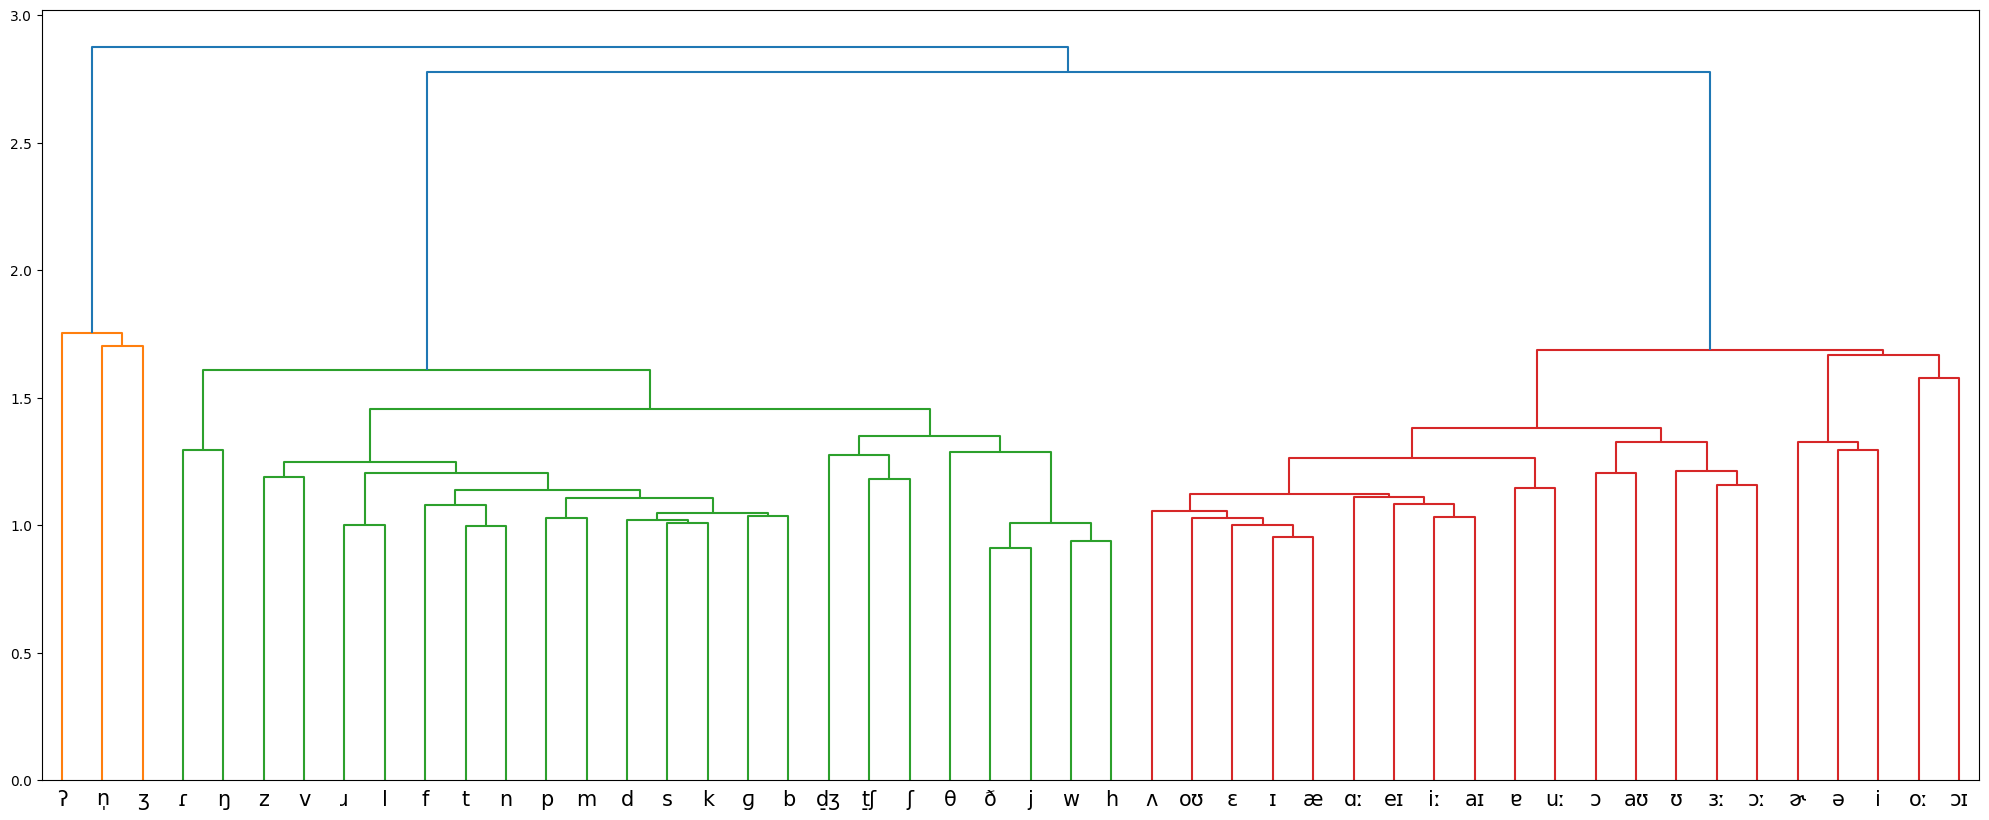

In [181]:
# plot cluster tree
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

kmeans = KMeans(n_clusters=5)
kmeans.fit(input_embeddings)
labels = kmeans.labels_

def plot_dendogram(embeddings, phonemes):
    dist = pdist(embeddings)
    Z = linkage(dist, 'ward')
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels=phonemes)
    plt.xticks(rotation=0)
    plt.tick_params(axis='x', which='major', labelsize=15)
    plt.show()

plot_dendogram(input_embeddings, english_phonemes)


plt.show()



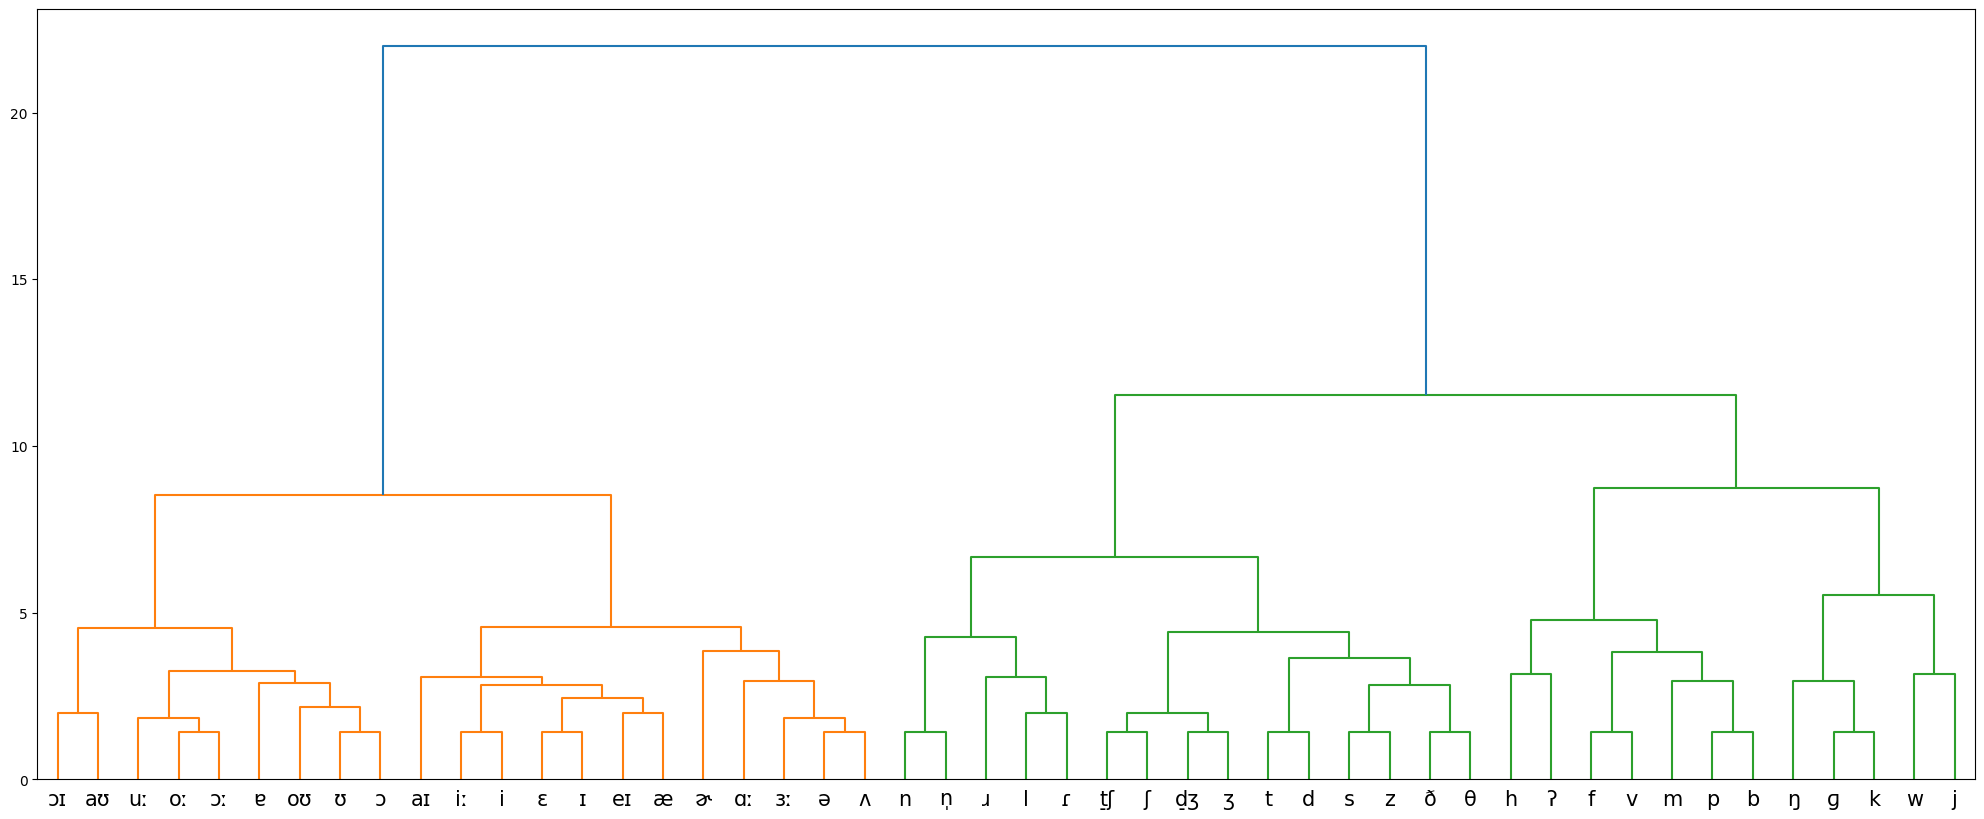

In [182]:
phoneme_map_vectors = []
for phoneme in english_phonemes:
    token_id = tokenizer.encode(phoneme, return_tensors='pt')
    phoneme_features = phoneme_map[token_id[0].item()]
    vec = []
    for f in phoneme_features:
        if f == 0:
            vec += [0,0,1]
        elif f == 1:
            vec += [0,1,0]
        elif f == 2:
            vec += [1,0,0]
    phoneme_map_vectors.append(vec)
phoneme_map_vectors

plot_dendogram(phoneme_map_vectors, english_phonemes)

In [208]:
def difference_between_two_phoneme(phoneme_1, phoneme_2):
    # Use phoible to find the features that differ between the two phonemes
    phoneme_1_features = english_phoneme_data[english_phoneme_data['Phoneme'] == phoneme_1].iloc[0]
    phoneme_2_features = english_phoneme_data[english_phoneme_data['Phoneme'] == phoneme_2].iloc[0]
    diff = []
    for feature in all_possible_features:
        if phoneme_1_features[feature] != phoneme_2_features[feature]:
            diff.append(feature)
    return diff

def difference_between_two_phoneme_sets(phonemes_1, phonemes_2):
    # Use phoible to find the features that differ between the two phonemes sets.
    # First find all features in common within two sets, then find the features that differ
    phoneme_1_features = [english_phoneme_data[english_phoneme_data['Phoneme'] == pho].iloc[0] for pho in phonemes_1]
    phoneme_2_features = [english_phoneme_data[english_phoneme_data['Phoneme'] == pho].iloc[0] for pho in phonemes_2]
    common_features_1 = {}
    common_features_2 = {}
    for feature in all_possible_features:
        features_1 = [pho[feature] for pho in phoneme_1_features]
        features_2 = [pho[feature] for pho in phoneme_2_features]
        if all([f == features_1[0] for f in features_1]) and all([f == features_2[0] for f in features_2]):
            common_features_1[feature] = features_1[0]
            common_features_2[feature] = features_2[0]
    diff = []
    print(common_features_1)
    print(common_features_2)
    for feature in common_features_1.keys():
        if common_features_1[feature] != common_features_2[feature]:
            diff.append(feature + ' ' + str(common_features_1[feature]) + ' ' + str(common_features_2[feature]))
    return diff

print(difference_between_two_phoneme_sets(['m'], ['n']))
print(difference_between_two_phoneme_sets(['f','v','m','p','b'],['h','ʔ']))
print(difference_between_two_phoneme_sets(['f','v','m','p','b','h','ʔ'],['ɡ','k','w','j','ŋ']))


print(difference_between_two_phoneme_sets(['i','aɪ','iː','ɛ','ɪ','eɪ','æ'],['ɚ','ɑː','ɜː','ə','ʌ']))
print(difference_between_two_phoneme_sets(['ɐ', 'ʊ', 'uː', 'oː', 'ɔɪ', 'oʊ', 'ɔ', 'aʊ', 'ɔː'],['i','aɪ','iː','ɛ','ɪ','eɪ','æ','ɚ','ɑː','ɜː','ə','ʌ']))
print(difference_between_two_phoneme_sets(['ɔɪ','aʊ'],['ɐ','ʊ', 'uː', 'oː', 'oʊ', 'ɔ', 'ɔː']))
print(difference_between_two_phoneme_sets(['ʊ'],['ɔ']))


{'syllabic': '-', 'tone': '0', 'stress': '-', 'short': '-', 'long': '-', 'consonantal': '+', 'sonorant': '+', 'continuant': '-', 'delayedRelease': '0', 'approximant': '-', 'tap': '-', 'trill': '-', 'nasal': '+', 'lateral': '-', 'labial': '+', 'round': '-', 'labiodental': '-', 'coronal': '-', 'anterior': '0', 'distributed': '0', 'strident': '0', 'dorsal': '-', 'high': '0', 'low': '0', 'front': '0', 'back': '0', 'tense': '0', 'retractedTongueRoot': '-', 'advancedTongueRoot': '-', 'periodicGlottalSource': '+', 'epilaryngealSource': '-', 'spreadGlottis': '-', 'constrictedGlottis': '-', 'fortis': '-', 'lenis': '-', 'raisedLarynxEjective': '-', 'loweredLarynxImplosive': '-', 'click': '-'}
{'syllabic': '-', 'tone': '0', 'stress': '-', 'short': '-', 'long': '-', 'consonantal': '+', 'sonorant': '+', 'continuant': '-', 'delayedRelease': '0', 'approximant': '-', 'tap': '-', 'trill': '-', 'nasal': '+', 'lateral': '-', 'labial': '-', 'round': '0', 'labiodental': '0', 'coronal': '+', 'anterior': '+'

In [195]:
print(vowels)

['iː', 'ɛ', 'ɐ', 'eɪ', 'ɪ', 'æ', 'ɑː', 'ə', 'ʊ', 'uː', 'i', 'aɪ', 'oː', 'ɔɪ', 'ʌ', 'oʊ', 'ɔ', 'aʊ', 'ɜː', 'ɔː', 'ɚ']


## Prediction Error

Plotting of prediction error from a model given a prompt.

In [218]:
from src.segmentation.segment import GPT2FeaturesSegmenter, GPT2Segmenter
segmenter = GPT2Segmenter(model, tokenizer, dataset['valid']['phonemized_utterance'], stride=1)
#segmenter = GPT2FeaturesSegmenter(model, tokenizer, dataset['train']['phonemized_utterance'][:3000], stride=0)

100%|██████████| 8878/8878 [07:37<00:00, 19.42it/s]


In [210]:
from scipy.optimize import minimize_scalar

def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)

        cutoff = cutoffs[i] if cutoffs else None
        for j in range(len(ax.get_xticklabels())):
            tick = ax.get_xticklabels()[j]
            is_boundary = data.Starts[j]
            y_value = data[measures[i]].values[j]
            # Add vertical line at boundary
            if is_boundary:
                ax.axvline(x=j, color='grey', alpha=0.5)
            # Set tick to green if correct boundary according to cutoff
            if cutoff:
                tick.set_color('green' if (is_boundary and y_value >= cutoff) or (not is_boundary and y_value < cutoff) else 'red')

        # Add cutoff line   
        if cutoff:
            ax.axhline(y=cutoff, color='pink', alpha=0.5)

    ax.set_xlabel('Phonemes')
    plt.show()

def get_cutoff_data(segmenter, measure, cutoffs):
    """ Get results for a specific measure at different cutoffs. """
    all_results = []
    for cutoff in cutoffs:
        results = segmenter.evaluate_cutoff_segmentation(measure, cutoff)
        results['Cutoff'] = cutoff
        all_results.append(results)
    all_results = pd.concat(all_results)
    return all_results

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = seaborn.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    seaborn.lineplot(results, x=measure1, y=measure2)
    plt.show()

def plot_optimal_cutoff(segmenter, measure, score, cutoff):

    min, max = segmenter.processed_utterances[measure].min(), segmenter.processed_utterances[measure].max()
    cutoffs = np.linspace(min, max, 50)
    scores = [segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score] for cutoff in cutoffs]
    graph = seaborn.lineplot(x=cutoffs, y=scores)
    graph.axvline(cutoff, color='grey', alpha=0.5)
    plt.show()

def summarise_segmentation(segmenter, measure='Entropy', score='type_fscore', cutoff=None, show_plots=False):
    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))
    if cutoff:
        best_cutoff = cutoff
        best_result = segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score]
    else:
        best_cutoff, best_result = segmenter.find_best_cutoff(measure, score)
        print('Best cutoff:', best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))
    if show_plots:
        plot_optimal_cutoff(segmenter, measure, score, best_cutoff)


In [211]:
all_measures = ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Increase in Boundary Prediction', 'Loss', 'Increase in Loss', 'Rank', 'Increase in Rank']
all_measures = ['Entropy', 'Boundary Prediction', 'Loss', 'Rank']
best_cutoffs = {measure : segmenter.find_best_cutoff(measure, 'boundary_noedge_fscore')[0] for measure in all_measures}

print("Best cutoffs: ", best_cutoffs)

Best cutoffs:  {'Entropy': 2.104668322844612, 'Boundary Prediction': 0.0014540447080540894, 'Loss': 1.77869607941929, 'Rank': 1.2647505916335922}


In [212]:
# segmenter.processed_utterances['Majority Vote Cutoff'] = 0
# segmenter.processed_utterances['Majority Vote Spike'] = 0
# for measure in all_measures:
#     segmenter.processed_utterances['Majority Vote Cutoff'] += (segmenter.processed_utterances[measure] >= best_cutoffs[measure]).astype(int)
#     shift_left = segmenter.processed_utterances[measure].shift(1)
#     shift_right = segmenter.processed_utterances[measure].shift(-1)
#     segmenter.processed_utterances['Majority Vote Spike'] += ((segmenter.processed_utterances[measure] > shift_left) & (segmenter.processed_utterances[measure] > shift_right)).astype(int)

segmenter.add_majority_vote(best_cutoffs)

best_cutoffs['Majority Vote Cutoff'] = 0.5
best_cutoffs['Majority Vote Spike'] = 0.5
all_measures += ['Majority Vote Cutoff', 'Majority Vote Spike']

In [213]:
example_utterance = segmenter.processed_utterances.loc[0:64].copy()
example_utterance.Phoneme = example_utterance.Phoneme.apply(lambda x: x if x != 'UTT_BOUNDARY' else ' ')

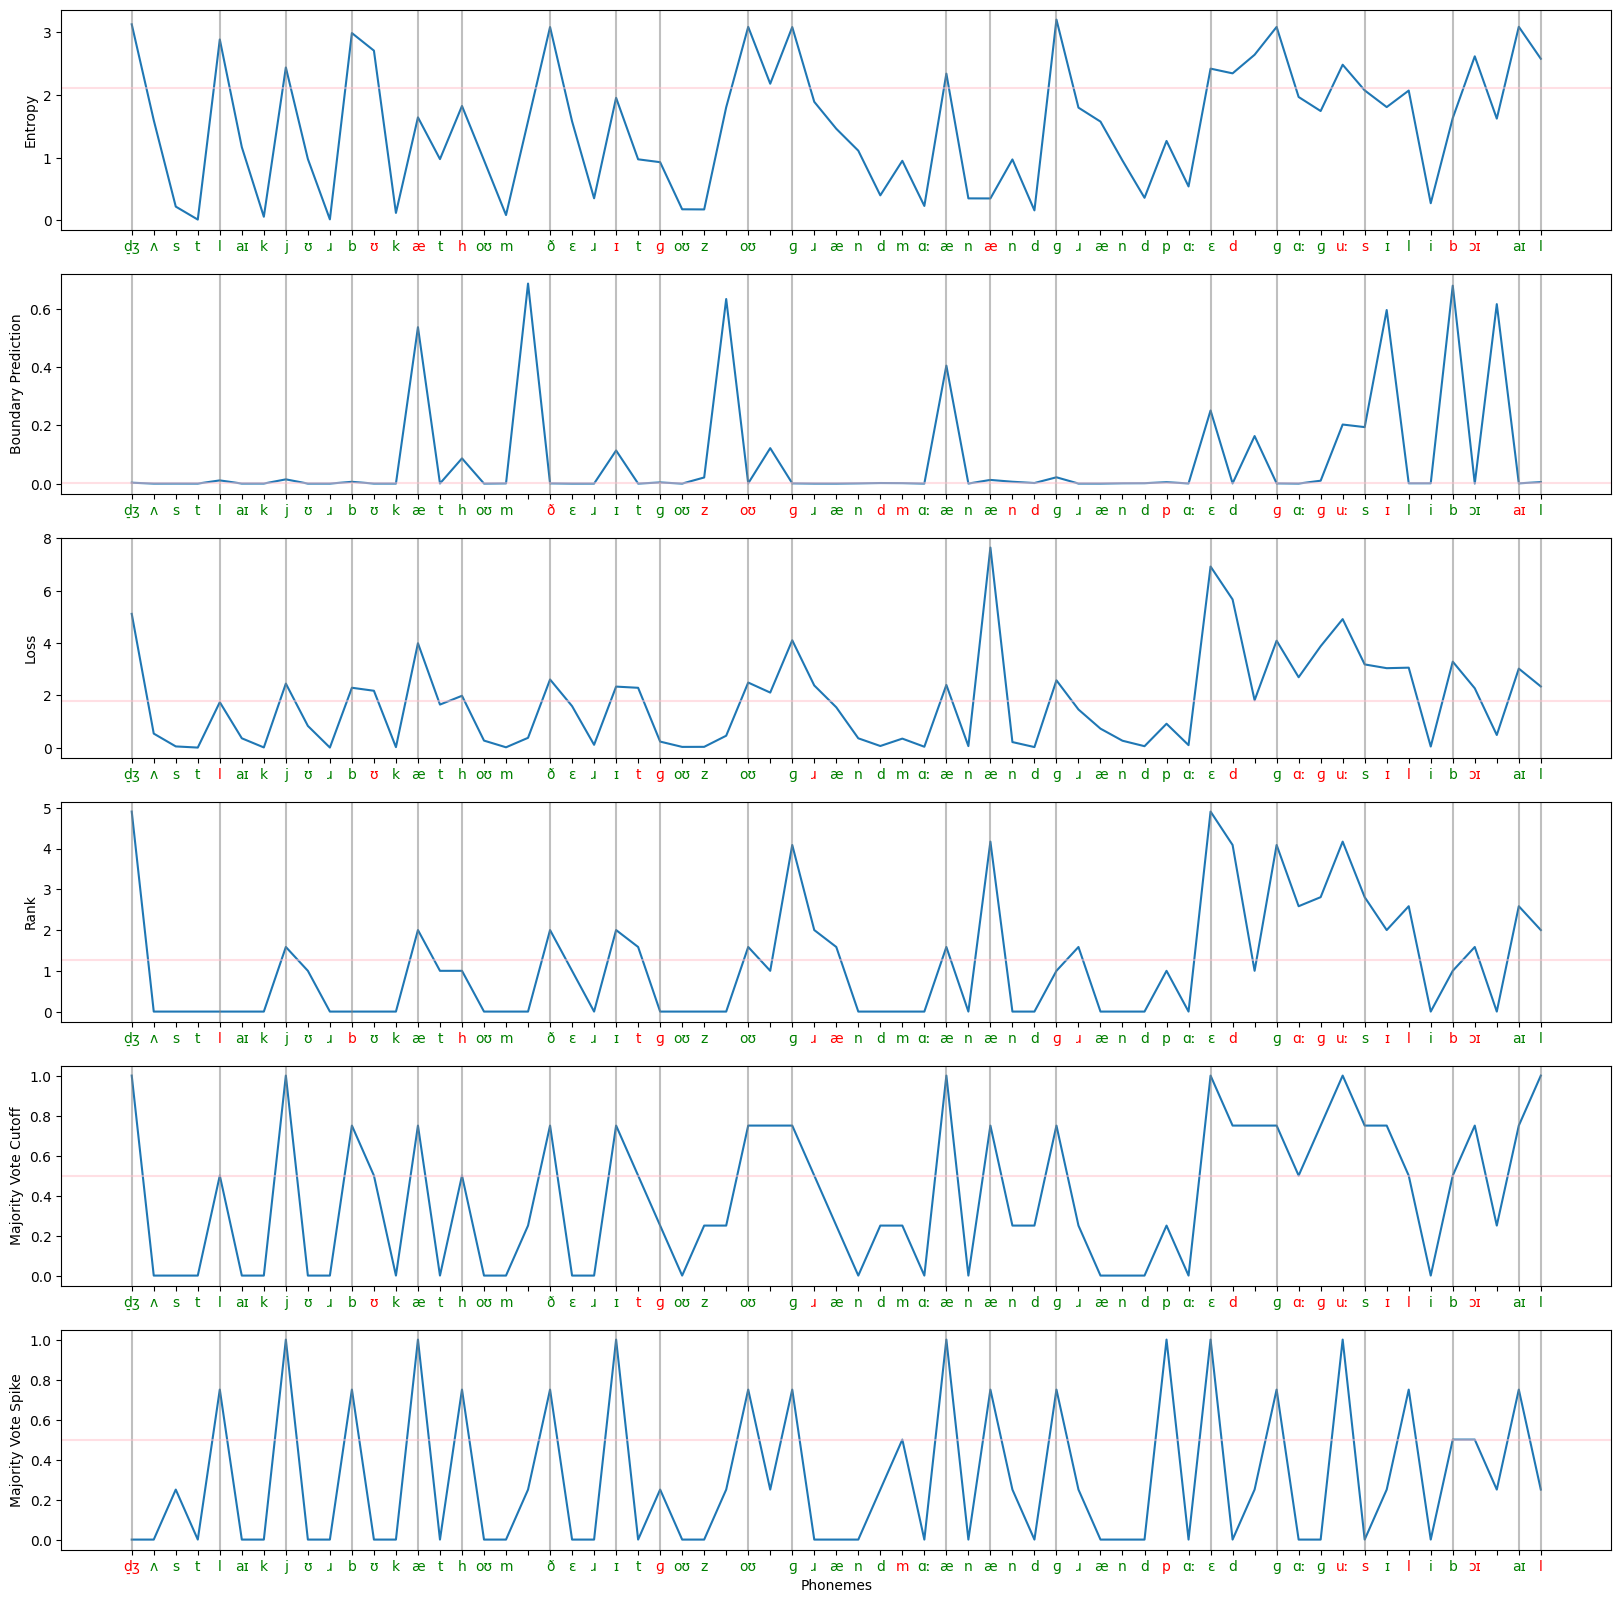

d̠ʒʌstlaɪkjʊɹbʊkæthoʊm ðɛɹɪtɡoʊz oʊ ɡɹændmɑːænændɡɹændpɑːɛd ɡɑːɡuːsɪlibɔɪ aɪl


In [214]:
plot_utterance(example_utterance, list(best_cutoffs.keys()), list(best_cutoffs.values()))
#plot_utterance(data, ['Feature Loss', 'Feature Entropy', 'Loss Deviation', 'Boundary Feature Prediction'], [0.01, 0.3, 0.01, 0.5])
print(''.join(list(example_utterance.Phoneme)))


Entropy
Spike type_fscore: 46.52
Best type_fscore at cutoff 2.104668322844612: 34.61


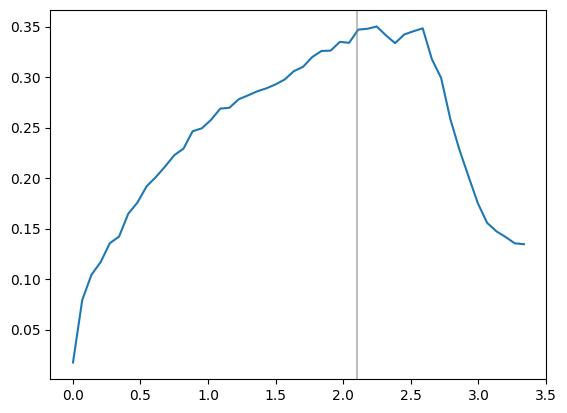


Boundary Prediction
Spike type_fscore: 50.4
Best type_fscore at cutoff 0.0014540447080540894: 44.5


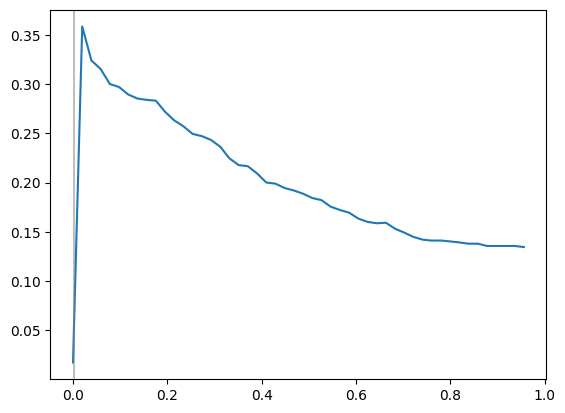


Loss
Spike type_fscore: 40.82
Best type_fscore at cutoff 1.77869607941929: 29.35


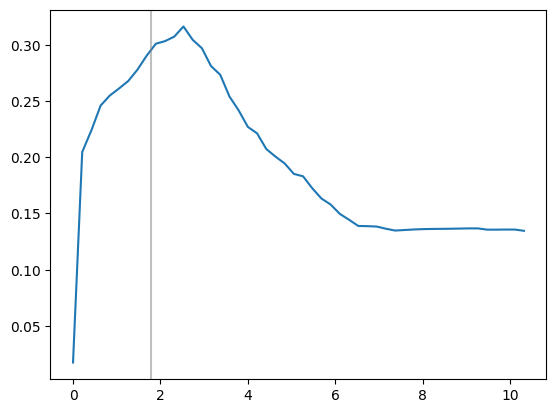


Rank
Spike type_fscore: 39.87
Best type_fscore at cutoff 1.2647505916335922: 27.63


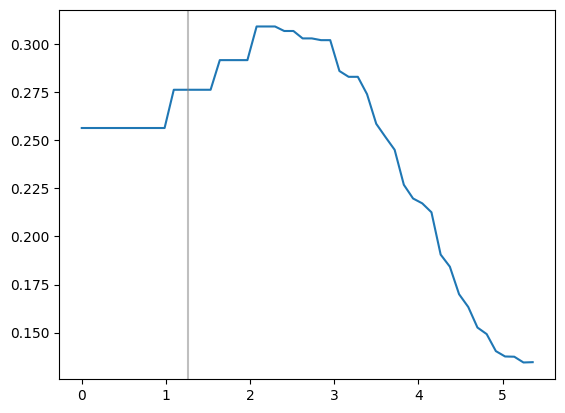


Majority Vote Cutoff
Spike type_fscore: 52.32
Best type_fscore at cutoff 0.5: 42.65


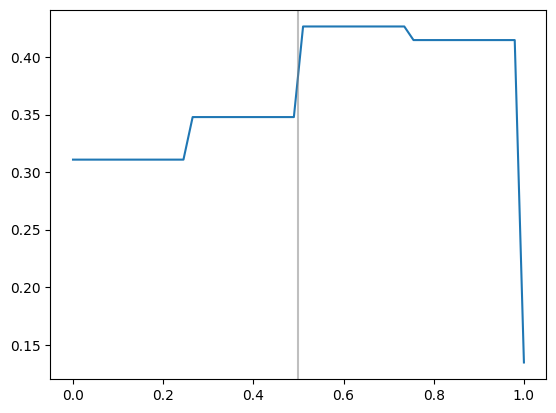


Majority Vote Spike
Spike type_fscore: 42.18
Best type_fscore at cutoff 0.5: 51.97


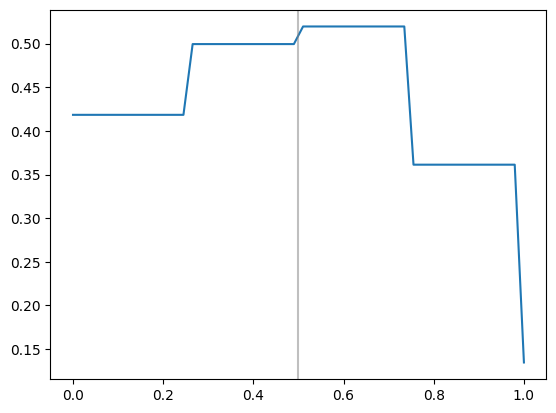

In [215]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', best_cutoffs[measure], show_plots=True)
#for measure in ['Feature Loss', 'Increase in Feature Loss', 'Feature Entropy', 'Increase in Feature Entropy', 'Loss Deviation', 'Increase in Loss Deviation', 'Boundary Feature Prediction', 'Increase in Boundary Feature Prediction']:


Entropy
Spike type_fscore: 46.52
Best cutoff: 2.4607572052988247
Best type_fscore at cutoff 2.4607572052988247: 34.47


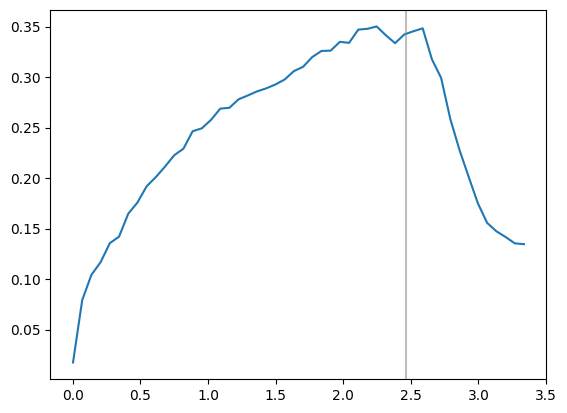


Boundary Prediction
Spike type_fscore: 50.4
Best cutoff: 0.0022447964697928724
Best type_fscore at cutoff 0.0022447964697928724: 46.23


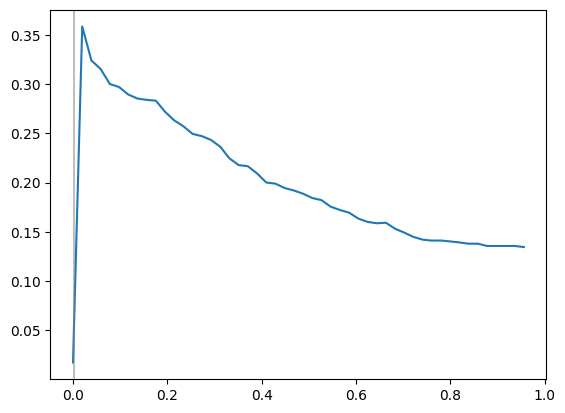


Loss
Spike type_fscore: 40.82
Best cutoff: 2.6595090871084035
Best type_fscore at cutoff 2.6595090871084035: 31.13


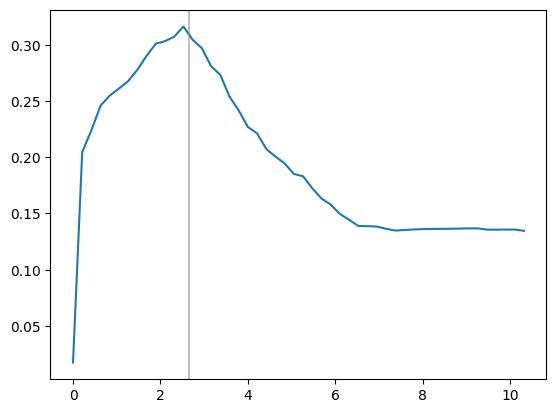


Rank
Spike type_fscore: 39.87
Best cutoff: 2.046408856602199
Best type_fscore at cutoff 2.046408856602199: 30.93


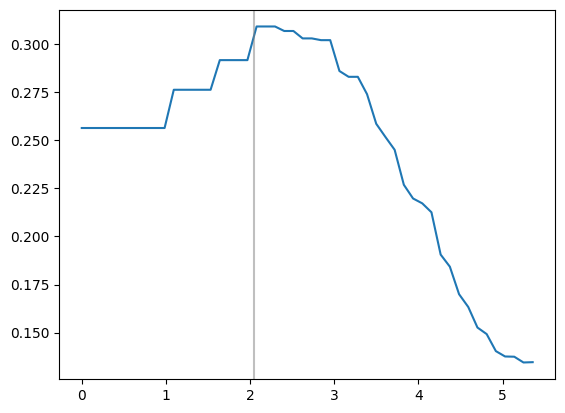


Majority Vote Cutoff
Spike type_fscore: 52.32
Best cutoff: 0.6178100468266169
Best type_fscore at cutoff 0.6178100468266169: 42.65


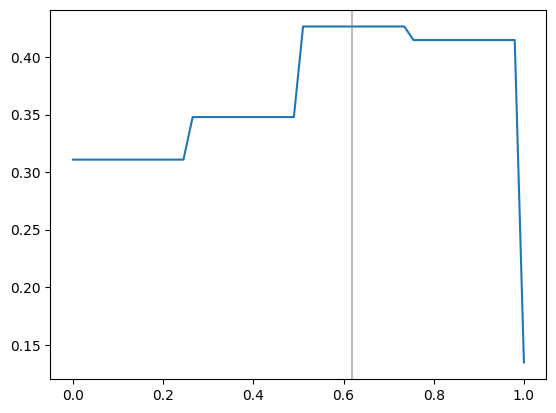


Majority Vote Spike
Spike type_fscore: 42.18
Best cutoff: 0.38197153727375543
Best type_fscore at cutoff 0.38197153727375543: 49.95


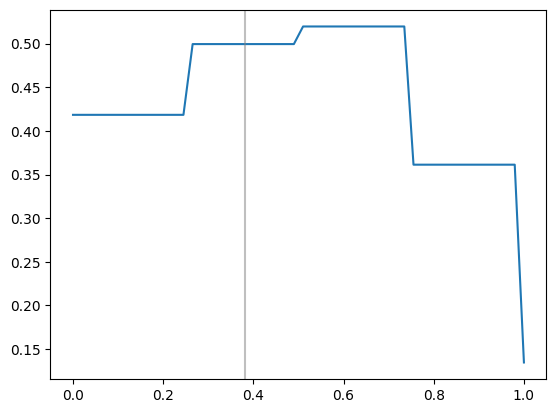

In [216]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', show_plots=True)

Spike boundary_noedge_fscore: 81.24
Best boundary_noedge_fscore at cutoff 0.5: 70.88


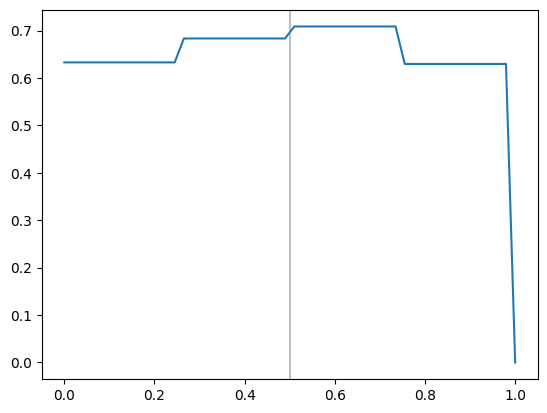

Spike boundary_noedge_fscore: 75.95
Best boundary_noedge_fscore at cutoff 0.5: 78.41


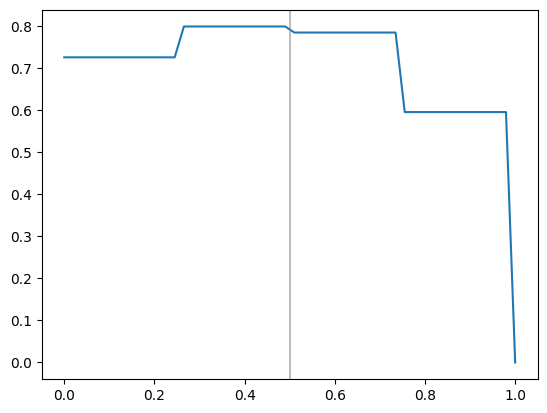

In [217]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=True, cutoff=best_cutoffs['Majority Vote Cutoff'])
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=True, cutoff=best_cutoffs['Majority Vote Spike'])

Spike boundary_noedge_fscore: 78.12
Best cutoff: 0.5665539985477035
Best boundary_noedge_fscore at cutoff 0.5665539985477035: 72.08


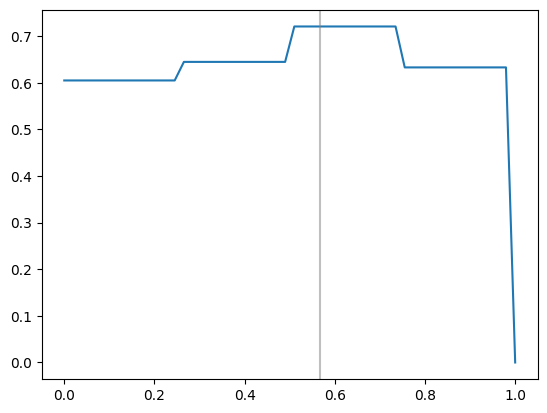

Spike boundary_noedge_fscore: 73.9
Best cutoff: 0.381971597220446
Best boundary_noedge_fscore at cutoff 0.381971597220446: 76.23


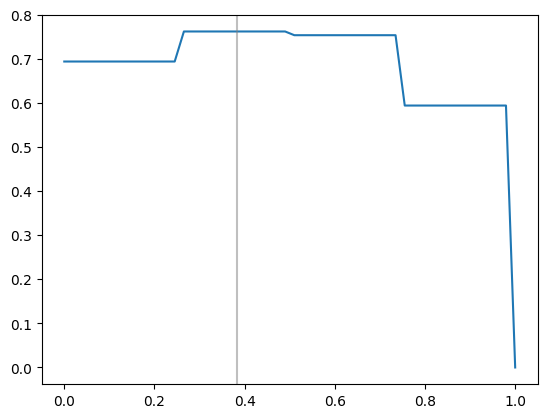

In [16]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=True)
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=True)